In [34]:
from assign_patches import AssignPatchesOperation
import pandas as pd
import columns as c
import numpy as np
from PIL import Image
import cv2

In [43]:
df_image_metadata = pd.read_parquet('data/cleansed/df_subsets.parquet').iloc[:10] # <- selected only 10 rows for visualization purposes
df_cell_locations = pd.read_parquet('data/standardized/df_cell_locations.parquet')

In [44]:
df_results = AssignPatchesOperation().transform(df_cell_locations=df_cell_locations, df_image_metadata=df_image_metadata,
                                                new_patch_size=256, input_size=1080, minimal_coverage_percentage=0.8)

100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


<Axes: >

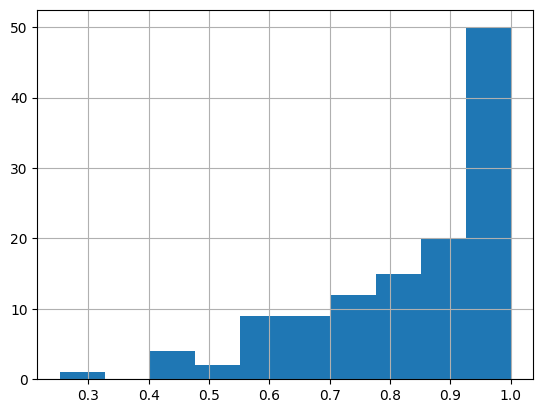

In [45]:
df_results["patch_coverage_percentage"].hist()

<Axes: >

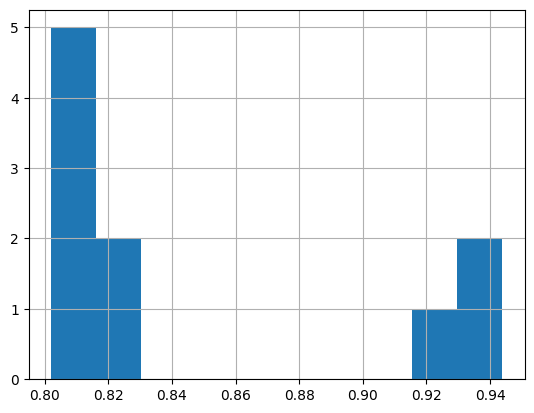

In [46]:
df_results.groupby([c.ASSAY_PLATE_BARCODE, c.WELL_POSITION, c.FIELD])["global_coverage_percentage"].first().hist()

In [47]:
def visualize_bboxes(image, bboxes, color=(0, 255, 0)):
    for bbox in bboxes.to_dict(orient="records"):
        x_min, x_max, y_min, y_max = int(bbox[c.MIN_X]), int(bbox[c.MAX_X]), int(bbox[c.MIN_Y]), int(bbox[c.MAX_Y])
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
    return image

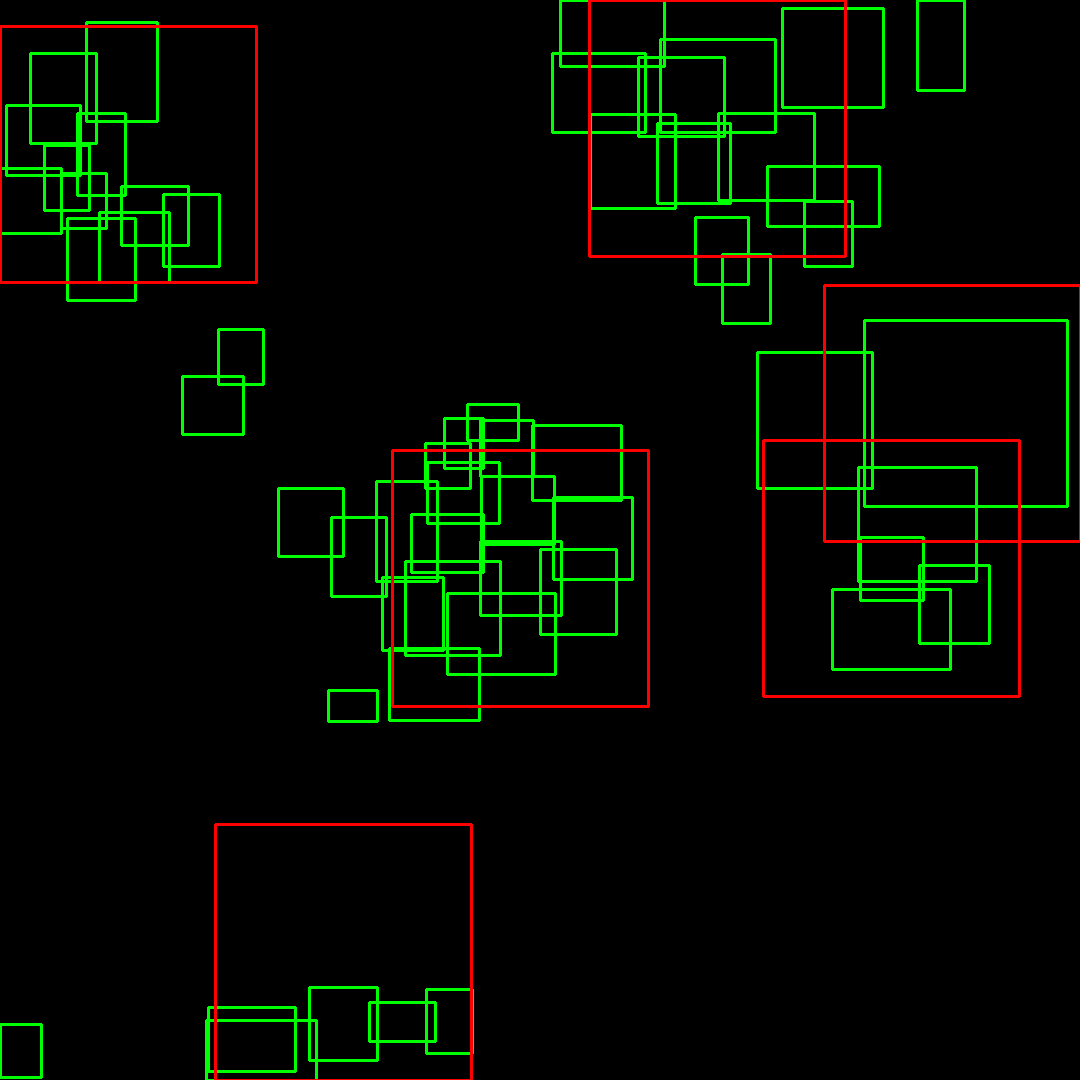

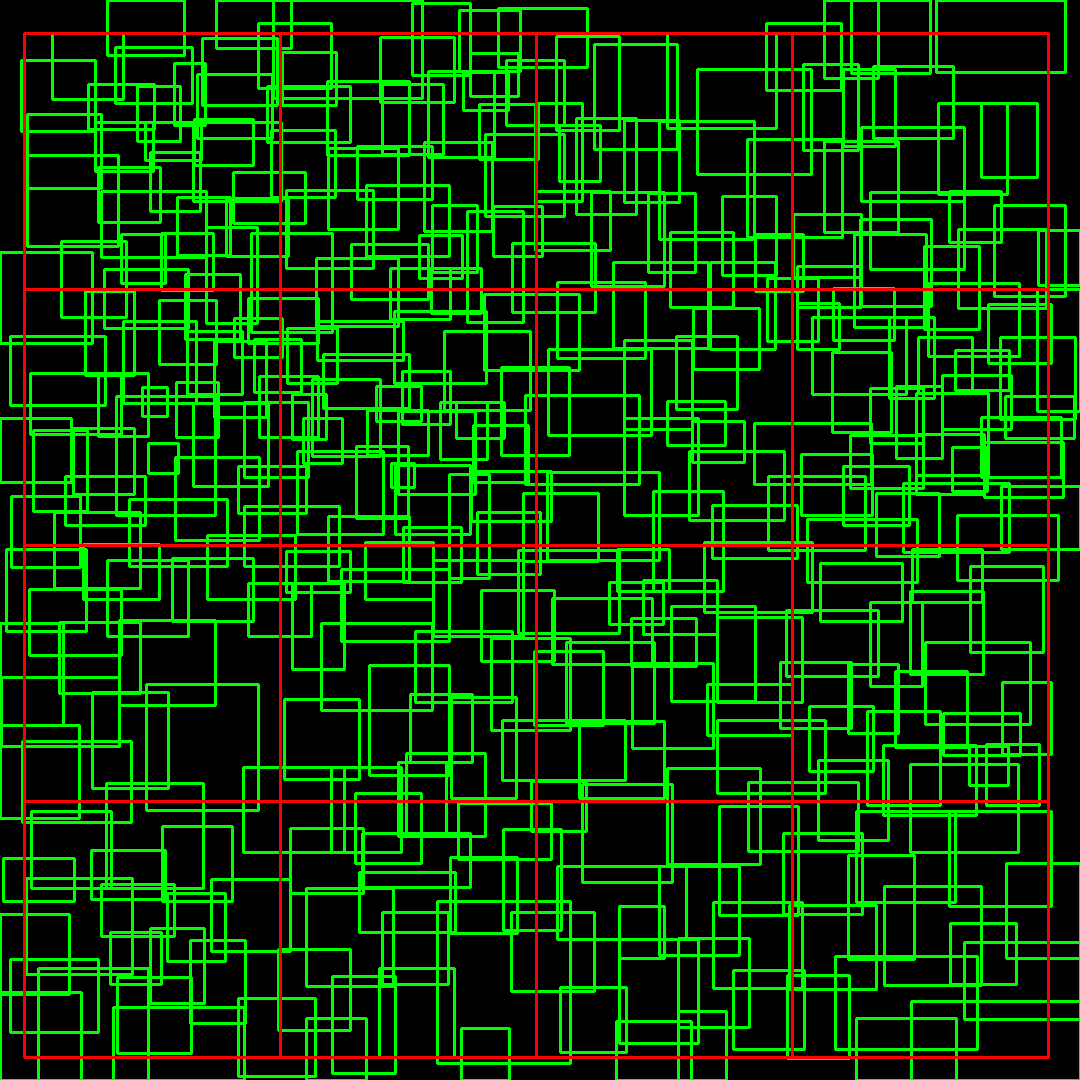

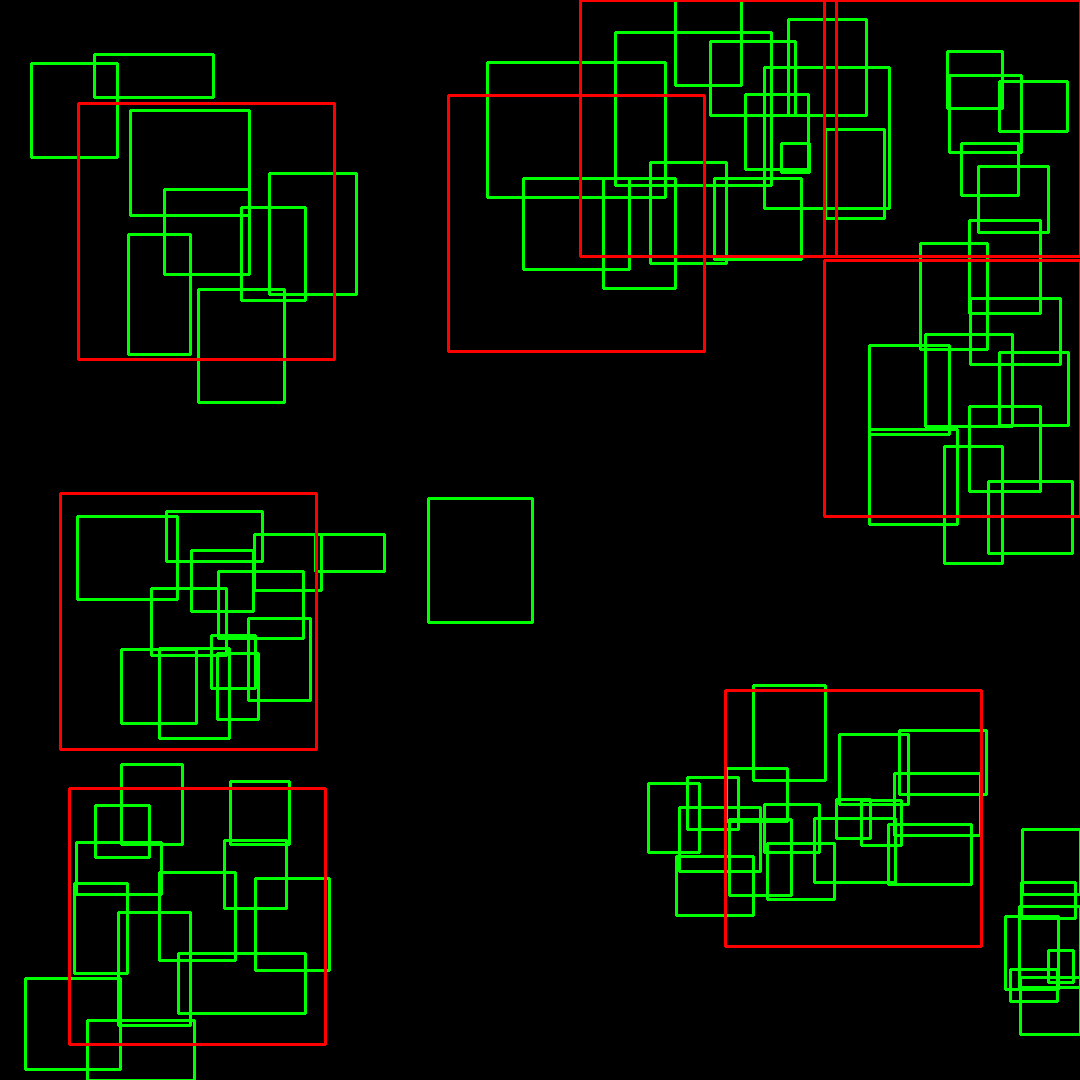

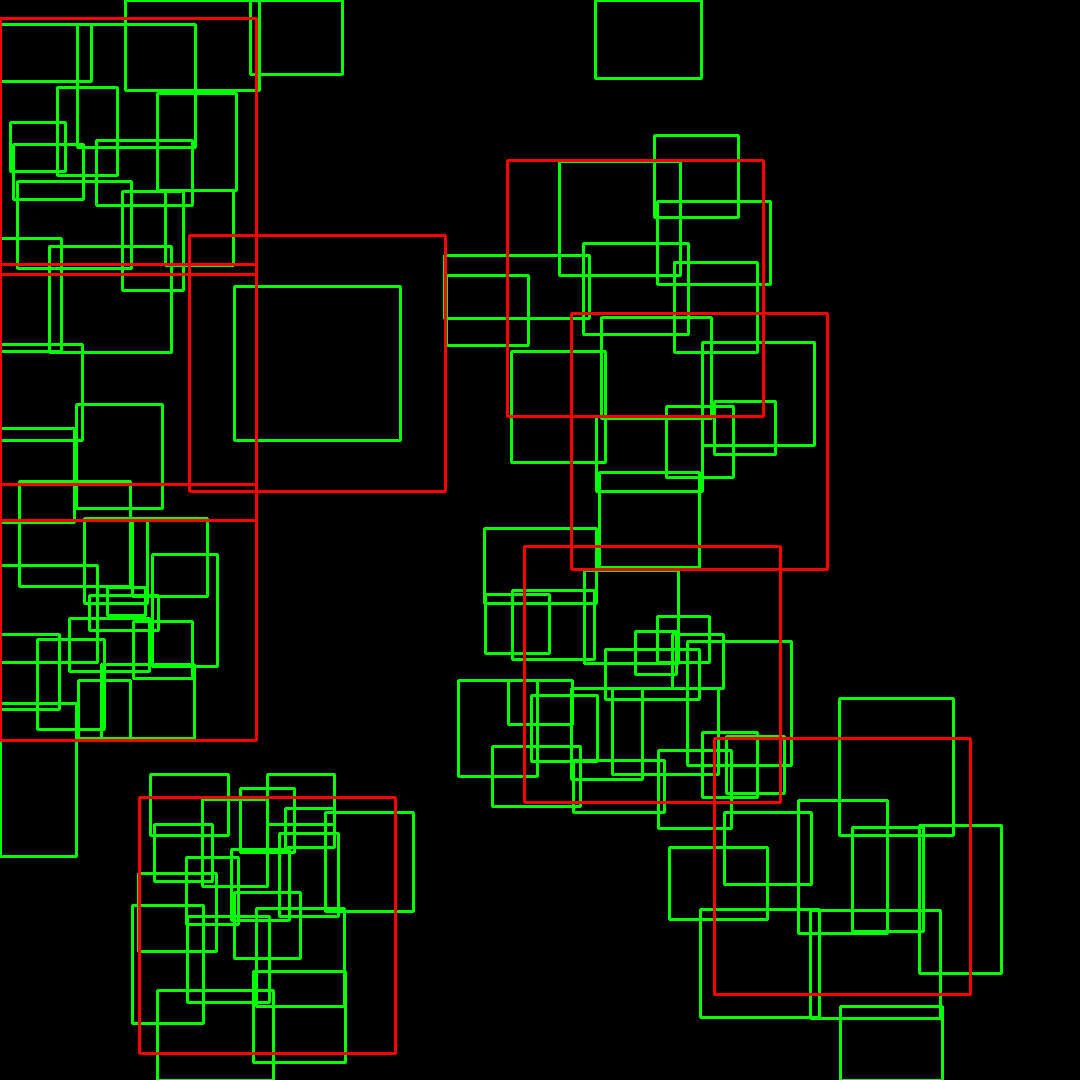

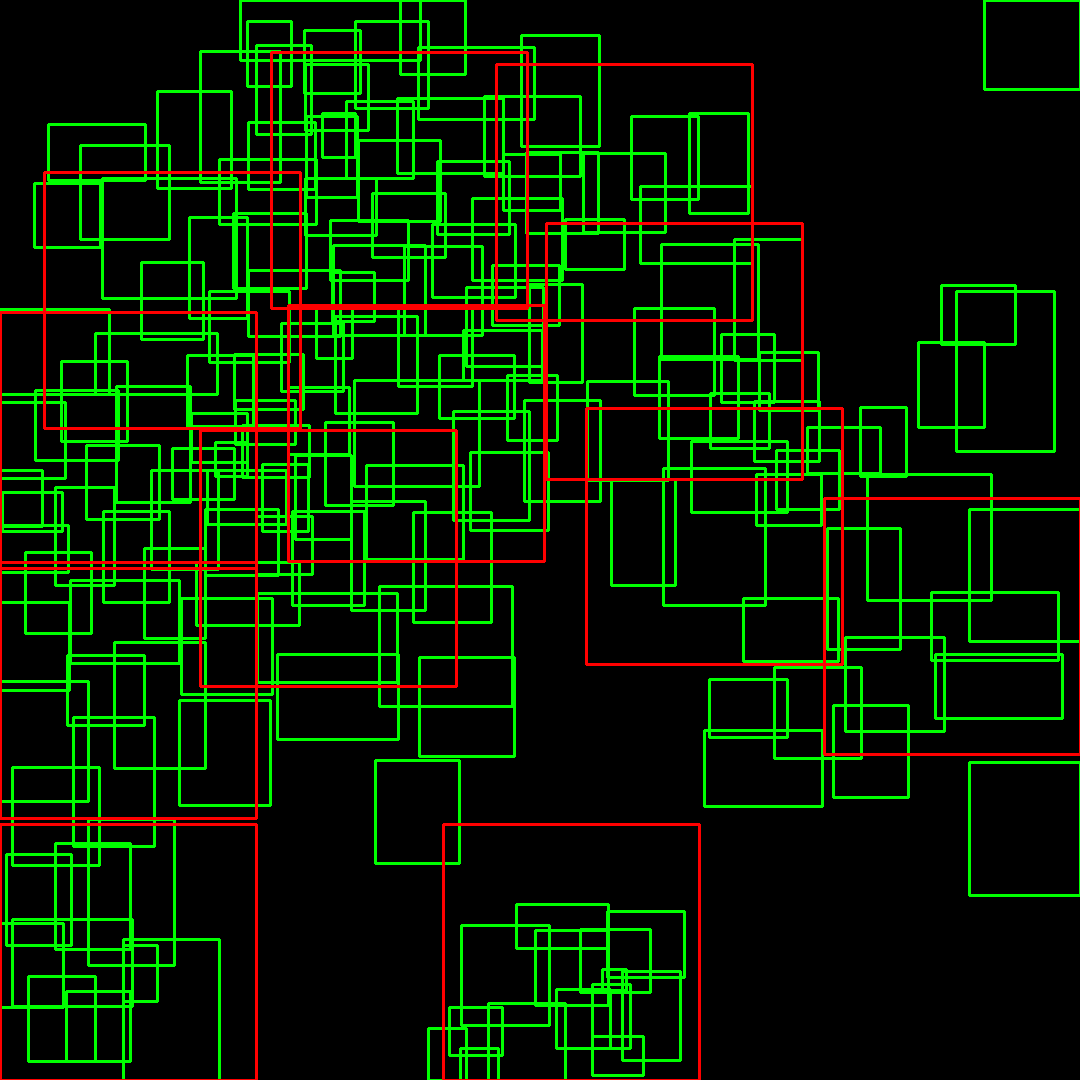

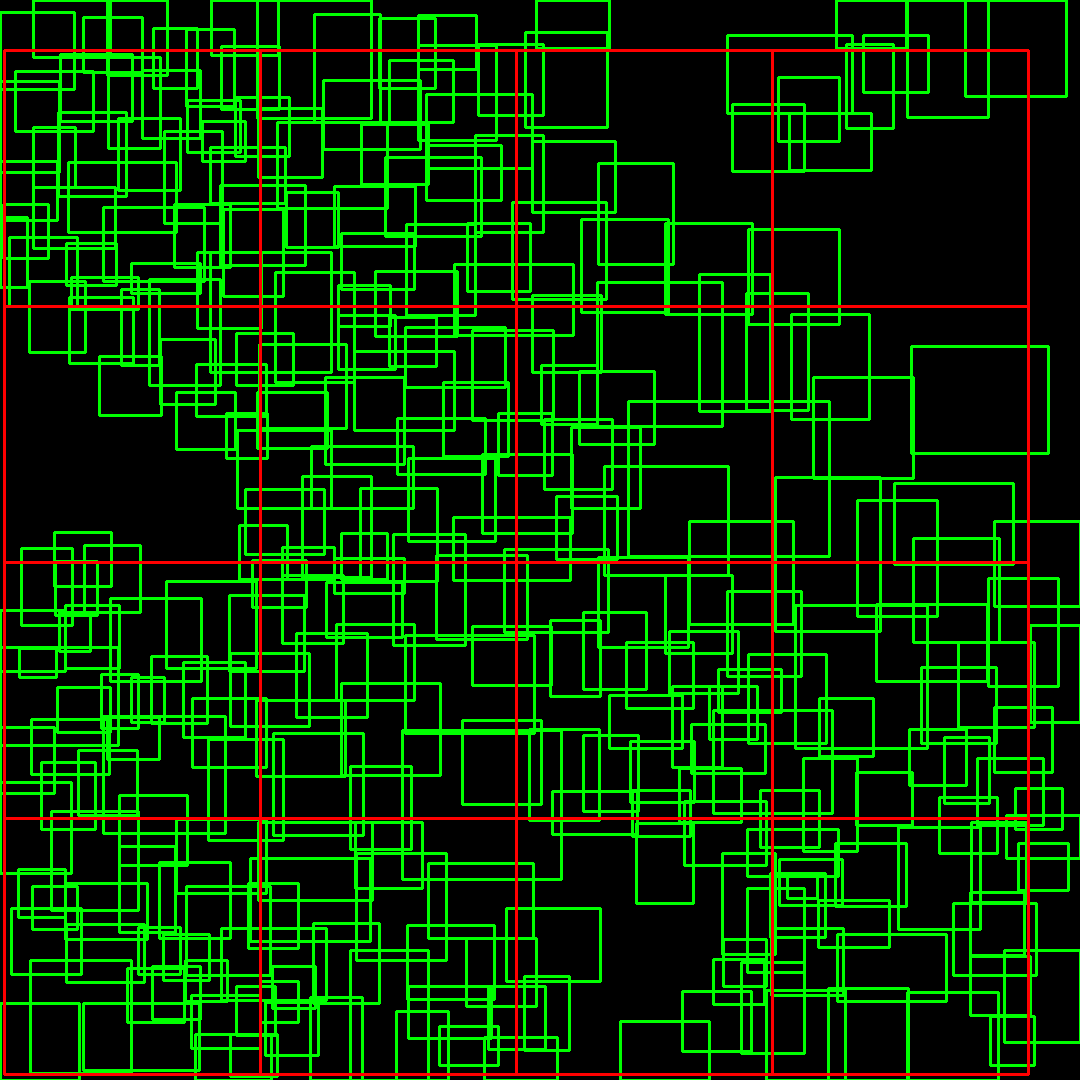

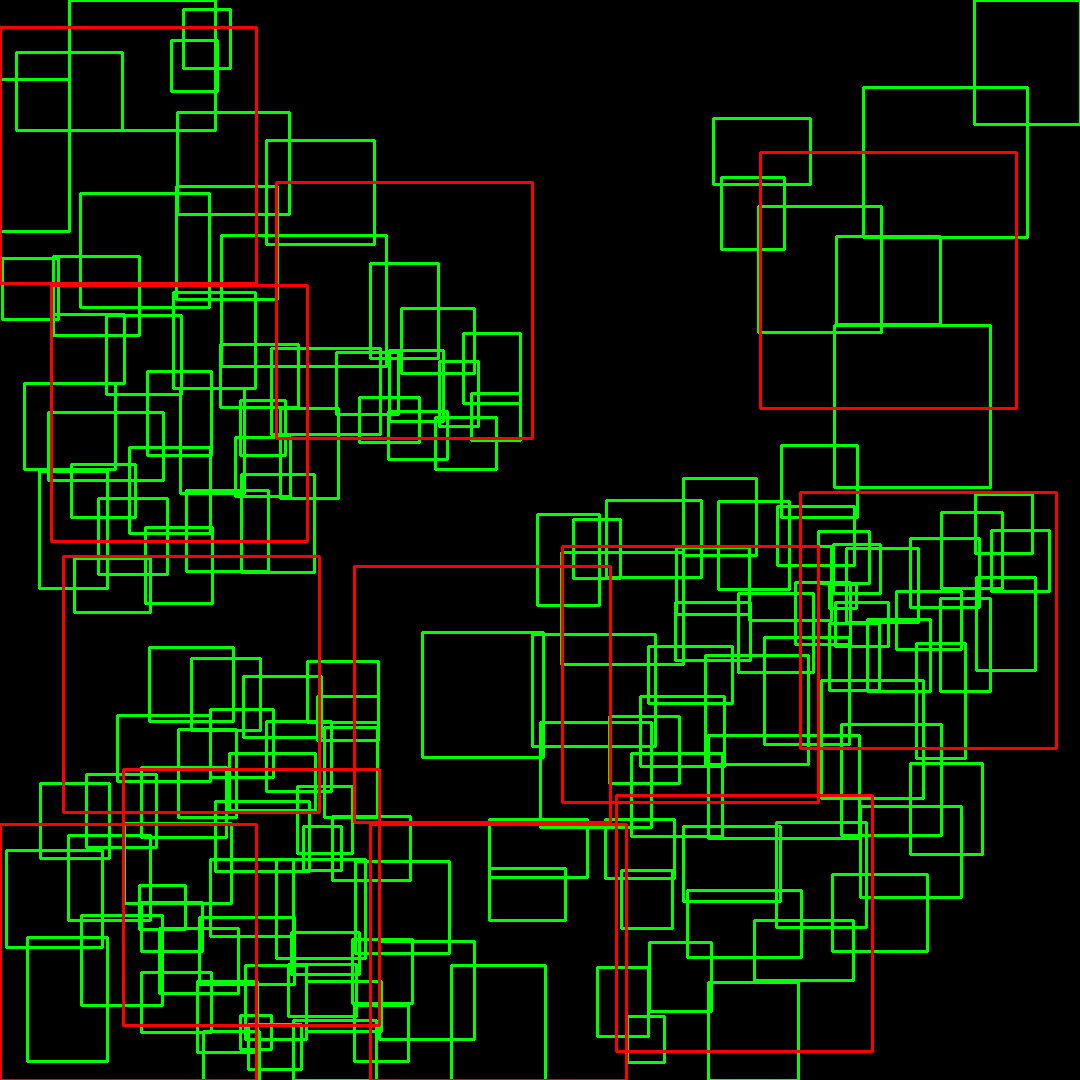

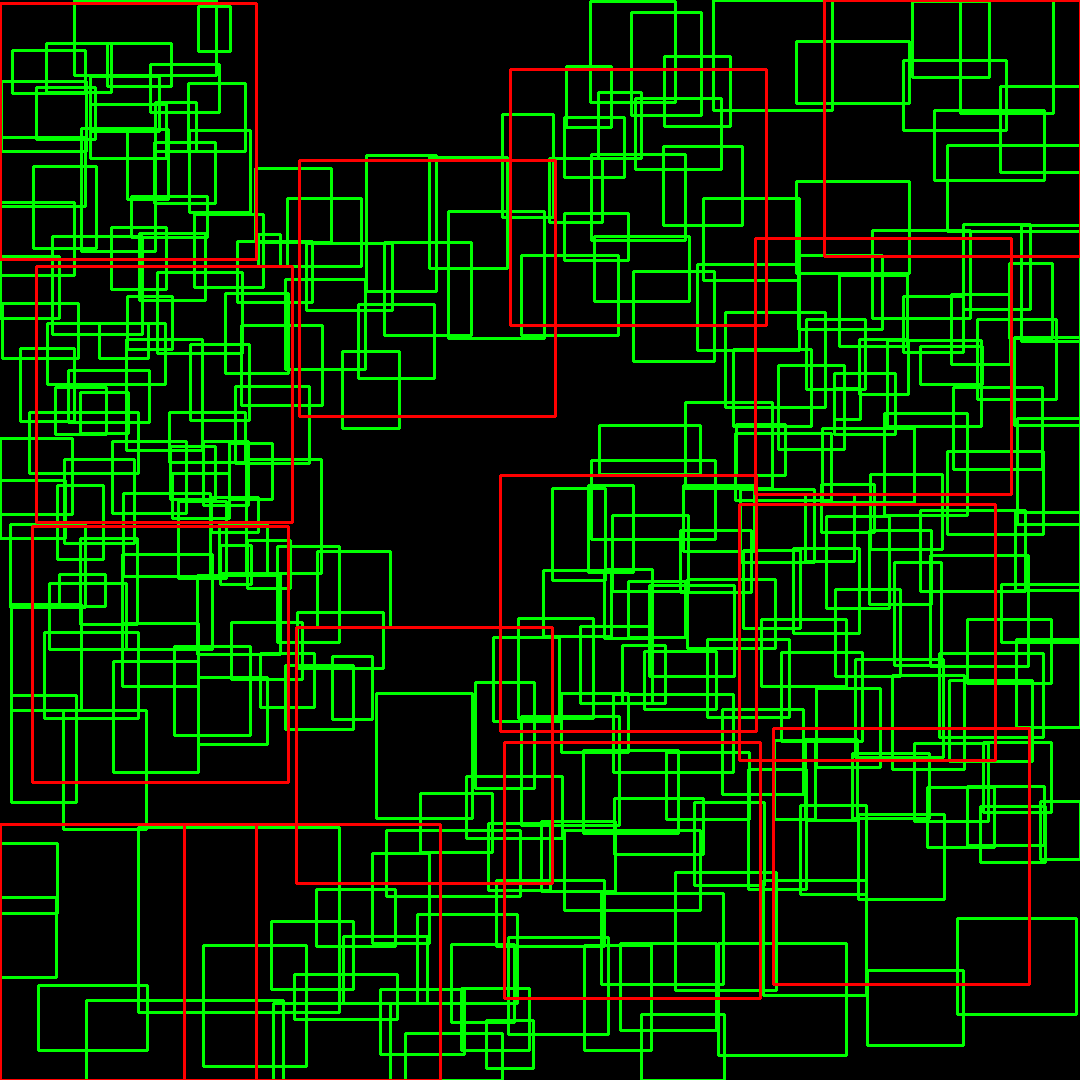

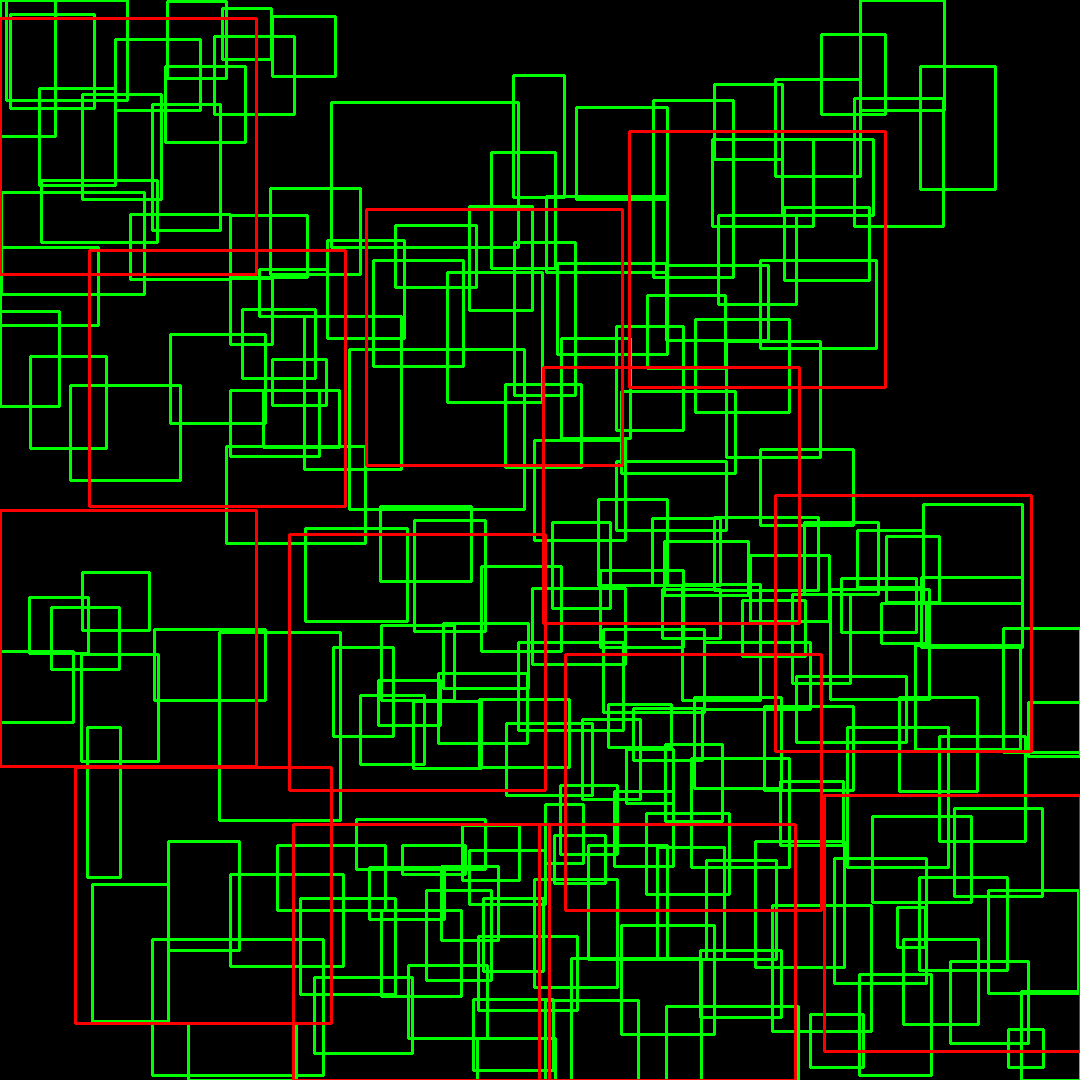

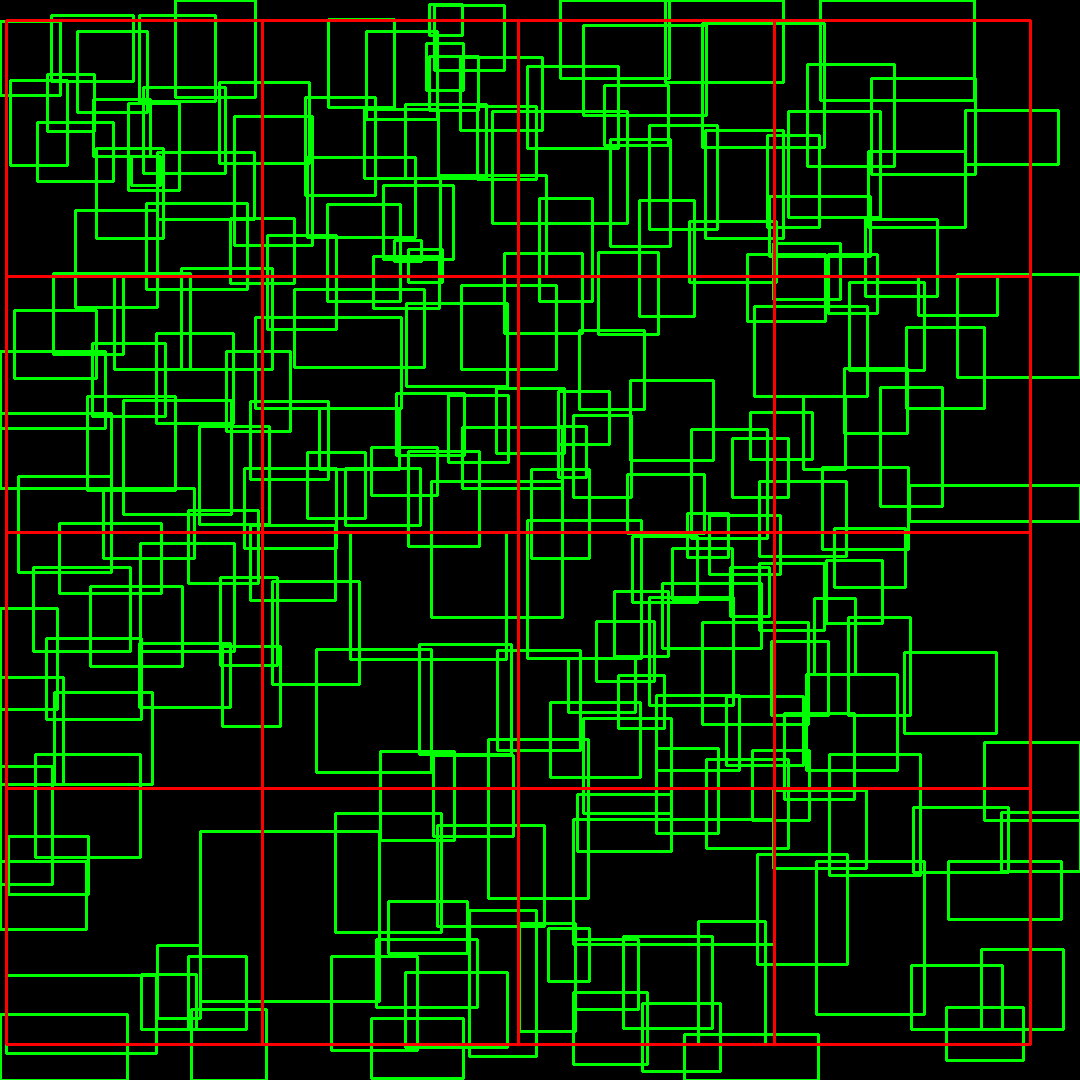

In [48]:
primary_keys = [c.ASSAY_PLATE_BARCODE, c.WELL_POSITION, c.FIELD]
bbox_columns = [c.MAX_X, c.MAX_Y, c.MIN_X, c.MIN_Y]
for primary_key in df_image_metadata[primary_keys].drop_duplicates().to_dict(orient='records'):
    original_bboxes = df_cell_locations.query(f"({c.ASSAY_PLATE_BARCODE} == '{primary_key[c.ASSAY_PLATE_BARCODE]}')"
                                              f" & ({c.WELL_POSITION} == '{primary_key[c.WELL_POSITION]}')"
                                              f" & ({c.FIELD} == '{primary_key[c.FIELD]}')")[bbox_columns]
    new_bboxes = df_results.query(f"({c.ASSAY_PLATE_BARCODE} == '{primary_key[c.ASSAY_PLATE_BARCODE]}')"
                                              f" & ({c.WELL_POSITION} == '{primary_key[c.WELL_POSITION]}')"
                                              f" & ({c.FIELD} == '{primary_key[c.FIELD]}')")[bbox_columns]
    
    image = np.zeros((1080,1080,3), np.uint8)
    image = visualize_bboxes(image, original_bboxes, (0, 255, 0))
    image = visualize_bboxes(image, new_bboxes, (255, 0, 0))
    display(Image.fromarray(image))